<a href="https://colab.research.google.com/github/Aleena24/real-image-SRGAN/blob/main/research_srgan_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# importing libraries

In [1]:
import glob
import os
import time
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale
from skimage.metrics import peak_signal_noise_ratio as psnr

from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# importing dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preprocessing

In [3]:
pip install opencv-python-headless numpy

# Image enhancement using Traditional Method

#Nearest Neighbor Interpolation




In [4]:
def nearest_neighbor_interpolation(image, scale_factor):
    original_height, original_width = image.shape[:2]
    new_height, new_width = int(original_height * scale_factor), int(original_width * scale_factor)

    # Create an empty array for the new image
    upscaled_image = np.zeros((new_height, new_width, image.shape[2]), dtype=image.dtype)

    for i in range(new_height):
        for j in range(new_width):
            # Find the nearest neighbor in the original image
            orig_x = int(j / scale_factor)
            orig_y = int(i / scale_factor)
            upscaled_image[i, j] = image[orig_y, orig_x]

    return upscaled_image

# Path to the image dataset
dataset_path = '/content/drive/MyDrive/research_dataset/BSD100'

# List all files in the dataset directory
image_files = [f for f in os.listdir(dataset_path) if os.path.isfile(os.path.join(dataset_path, f))]

# Select a random image from the dataset
random_image_file = random.choice(image_files)
image_path = os.path.join(dataset_path, random_image_file)

# Load the selected image
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    raise FileNotFoundError(f"Image not found at path: {image_path}")

# Perform Nearest Neighbor Interpolation
scale_factor = 2
upscaled_image = nearest_neighbor_interpolation(image, scale_factor)

# Resize the original image to match the upscaled image size for PSNR calculation
resized_original_image = cv2.resize(image, (upscaled_image.shape[1], upscaled_image.shape[0]), interpolation=cv2.INTER_LINEAR)

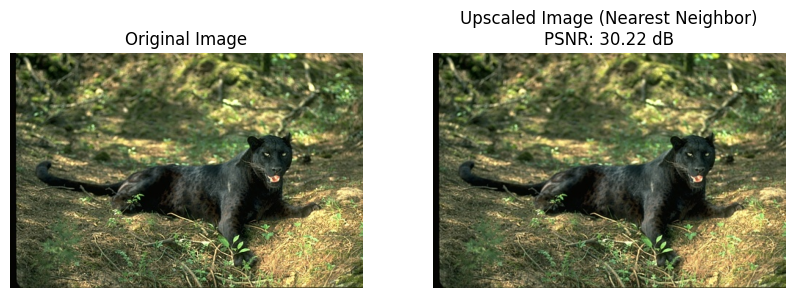

In [5]:
# Calculate PSNR between the resized original image and the upscaled image
psnr_value = psnr(resized_original_image, upscaled_image)

# Display the original and upscaled images using Matplotlib
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Upscaled Image (Nearest Neighbor)\nPSNR: {psnr_value:.2f} dB')
plt.imshow(cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


# Image enhancement using GAN Model

# Generator Network
commonly used in tasks like image super-resolution or image-to-image translation. Here with a combination of convolutional, residual, upsampling, and activation layers to transform input data into a desired output, such as high-resolution images.


In [7]:
def build_generator(input_shape):
    model = Sequential()
    model.add(Dense(128 * 8 * 8, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Reshape((8, 8, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(3, (4, 4), activation='tanh', strides=(2, 2), padding='same'))
    return model

# Discriminator Network

 discriminator network is designed to classify images as real or fake. It achieves this by applying convolutional operations to extract features from the input images and then using dense layers for classification. The use of LeakyReLU activation functions helps in preventing the network from getting stuck during training, and batch normalization aids in stabilizing the training process.


In [ ]:
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [ ]:
def compile_discriminator(discriminator):
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

# Adversial Network
the adversarial model combines the generator, discriminator, and VGG network. The generator aims to produce high-resolution images from low-resolution inputs, while the discriminator evaluates the generated images. The VGG network helps to capture the content of the generated images. During training, the discriminator's weights are fixed to focus on improving the generator's performance.


In [ ]:
def build_adversarial_model(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

In [ ]:
def compile_adversarial_model(adversarial_model):
    adversarial_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

In [ ]:
def compute_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
        return float('inf')
    PIXEL_MAX = 255.0
    psnr = 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
    return psnr


In [ ]:
def train_gan(generator, discriminator, adversarial_model, x_train, batch_size, epochs):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    d_losses, g_losses = [], []
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        real_imgs = x_train[idx]
        fake_imgs = generator.predict(np.random.randn(batch_size, latent_dim))

        d_loss_real = discriminator.train_on_batch(real_imgs, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        noise = np.random.randn(batch_size, latent_dim)
        g_loss = adversarial_model.train_on_batch(noise, real_labels)

        d_losses.append(d_loss[0])
        g_losses.append(g_loss)

        print(f"Epoch: {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}")

        if epoch % 10 == 0:
            save_images(generator, epoch)
            plot_losses(d_losses, g_losses)

In [ ]:

        # Select two random images from the dataset
        random_indices = np.random.randint(0, x_train.shape[0], 2)
        low_res_images = x_train[random_indices]
        high_res_images = np.array([generator.predict(np.random.randn(1, latent_dim))[0] for _ in range(2)])

        # Calculate PSNR for the selected images
        psnr_values = []
        for i in range(2):
            resized_low_res = cv2.resize(((low_res_images[i] + 1.0) * 127.5).astype(np.uint8),
                                         (high_res_images[i].shape[1], high_res_images[i].shape[2]))
            psnr_value = compute_psnr(resized_low_res, ((high_res_images[i] + 1.0) * 127.5).astype(np.uint8))
            psnr_values.append(psnr_value)

        print(f"Epoch: {epoch}, D Loss: {d_loss[0]}, G Loss: {g_loss}, PSNR Values: {psnr_values}")

        if epoch % 10 == 0:
            save_images(generator, epoch)
            plot_losses(d_losses, g_losses)

# Example usage:
latent_dim = 100  # Latent space dimension
input_shape = (latent_dim,)

# Build and compile the models
generator = build_generator(input_shape)
discriminator = build_discriminator((256, 256, 3))
compile_discriminator(discriminator)
adversarial_model = build_adversarial_model(generator, discriminator)
compile_adversarial_model(adversarial_model)

# Example dataset (replace this with your actual dataset)
x_train = np.random.rand(100, 64, 64, 3) * 2 - 1  # Random dataset with 100 low-resolution images

# Train the GAN
train_gan(generator, discriminator, adversarial_model, x_train, latent_dim, batch_size=32, epochs=100)

NameError: name 'x_train' is not defined

In [ ]:
def save_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.randn(examples, latent_dim)
    gen_imgs = generator.predict(noise)
    gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale images 0-1

    plt.figure(figsize=figsize)
    for i in range(gen_imgs.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(gen_imgs[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')
    plt.close()

In [ ]:
def plot_losses(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Training Loss")
    plt.legend()
    plt.savefig("gan_loss_curve.png")
    plt.close()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Example definitions (replace these with your actual data)
low_res_image_input = np.random.rand(1, 64, 64, 3) * 2 - 1  # Random low-resolution image
enhanced_image = np.random.rand(1, 256, 256, 3) * 255       # Random high-resolution image
psnr_value = 30.0                                            # Example PSNR value

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Low-Resolution Image')
plt.imshow(cv2.cvtColor(((low_res_image_input[0] + 1.0) * 127.5).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f'Enhanced High-Resolution Image\nPSNR: {psnr_value:.2f} dB')
plt.imshow(cv2.cvtColor(enhanced_image[0].astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, UpSampling2D, PReLU, BatchNormalization, Input, add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [9]:
lr_height = 24
lr_width = 24
lr_channels = 3
hr_height = lr_height * 4
hr_width = lr_width * 4
batch_size = 16
epochs = 10000

In [10]:
def load_dataset(path):
    images = []
    for filename in os.listdir(path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            img = tf.image.decode_image(tf.io.read_file(os.path.join(path, filename)), channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)
            images.append(img)
    return images

In [11]:
def preprocess_image(img, hr_shape):
    img = tf.image.resize(img, hr_shape)
    return img


In [12]:
# Build the generator model
def build_generator():
    def residual_block(x):
        filters = 64
        r = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        r = BatchNormalization(momentum=0.8)(r)
        r = PReLU(shared_axes=[1, 2])(r)
        r = Conv2D(filters, kernel_size=3, strides=1, padding='same')(r)
        r = BatchNormalization(momentum=0.8)(r)
        return add([r, x])

    def upsample(x):
        x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
        x = UpSampling2D(size=2)(x)
        x = PReLU(shared_axes=[1, 2])(x)
        return x

    # Input
    input_layer = Input(shape=(lr_height, lr_width, lr_channels))

    # Pre-residual block
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(input_layer)
    x = PReLU(shared_axes=[1, 2])(x)

    # Propagate through residual blocks
    r = residual_block(x)
    for _ in range(15):
        r = residual_block(r)

    # Post-residual block
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
    x = BatchNormalization(momentum=0.8)(x)
    x = add([x, r])

    # Upsampling
    x = upsample(x)
    x = upsample(x)

    # Generate high resolution output
    output_layer = Conv2D(lr_channels, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    return Model(input_layer, output_layer)

In [13]:
# Build the discriminator model
def build_discriminator():
    def d_block(layer_input, filters, strides=1, bn=True):
        d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
        d = PReLU(shared_axes=[1, 2])(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img = Input(shape=(hr_height, hr_width, lr_channels))

    d = d_block(img, 64, bn=False)
    d = d_block(d, 64, strides=2)
    d = d_block(d, 128)
    d = d_block(d, 128, strides=2)
    d = d_block(d, 256)
    d = d_block(d, 256, strides=2)
    d = d_block(d, 512)
    d = d_block(d, 512, strides=2)

    d = tf.keras.layers.Flatten()(d)
    d = tf.keras.layers.Dense(1024)(d)
    d = PReLU()(d)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(d)

    return Model(img, output_layer)

In [14]:
# VGG model for perceptual loss
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False

80134624/80134624 [==============================] - 0s 0us/step


In [15]:
def content_loss(hr, sr):
    hr = tf.image.resize(hr, (224, 224))
    sr = tf.image.resize(sr, (224, 224))
    hr_features = vgg(hr)
    sr_features = vgg(sr)
    return tf.keras.losses.MeanSquaredError()(hr_features, sr_features)


In [16]:
def adversarial_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)


In [17]:
# Compile models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss=adversarial_loss, optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])


In [18]:
hr = Input(shape=(hr_height, hr_width, lr_channels))
lr = Input(shape=(lr_height, lr_width, lr_channels))
sr = generator(lr)
discriminator.trainable = False
validity = discriminator(sr)
combined = Model(inputs=[lr, hr], outputs=[validity, sr])
combined.compile(loss=[adversarial_loss, content_loss], loss_weights=[1e-3, 1], optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))


In [19]:
images = load_dataset('/content/drive/MyDrive/research_dataset/BSD100')
hr_images = [preprocess_image(img, (hr_height, hr_width)) for img in images]
lr_images = [tf.image.resize(img, (lr_height, lr_width)) for img in hr_images]


In [20]:
for epoch in range(epochs):
    idx = np.random.randint(0, len(hr_images), batch_size)
    lr_imgs = np.array([lr_images[i] for i in idx])
    hr_imgs = np.array([hr_images[i] for i in idx])

In [21]:
    # Train discriminator
    fake_imgs = generator.predict(lr_imgs)
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(hr_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

1/1 [==============================] - 8s 8s/step


In [22]:
    # Train generator
    g_loss = combined.train_on_batch([lr_imgs, hr_imgs], [real_labels, hr_imgs])


In [23]:
 print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss[0]}]")

 if epoch % 1000 == 0:
        random_idx = random.randint(0, len(hr_images) - 1)
        test_lr = np.expand_dims(lr_images[random_idx], axis=0)
        test_hr = np.expand_dims(hr_images[random_idx], axis=0)
        generated_hr = generator.predict(test_lr)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.title('Low Resolution')
        plt.imshow((test_lr[0] * 0.5) + 0.5)  # Rescale for visualization
        plt.subplot(1, 3, 2)
        plt.title('Generated High Resolution')
        plt.imshow((generated_hr[0] * 0.5) + 0.5)  # Rescale for visualization
        plt.subplot(1, 3, 3)
        plt.title('Original High Resolution')
        plt.imshow((test_hr[0] * 0.5) + 0.5)  # Rescale for visualization
        plt.show()

9999/10000 [D loss: 2.44205442070961 | D accuracy: 46.875] [G loss: 0.09634268283843994]


1/1 [==============================] - 6s 6s/step
0/10000 [D loss: 1.7705023884773254 | D accuracy: 37.5] [G loss: 0.09554635733366013]
1/1 [==============================] - 0s 232ms/step


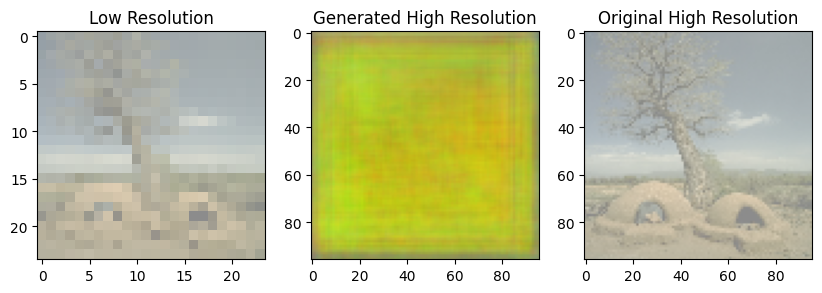

PSNR value: 4.545018196105957
1/1 [==============================] - 4s 4s/step


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.layers import Conv2D, UpSampling2D, PReLU, BatchNormalization, Input, add
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG19

lr_height = 24
lr_width = 24
lr_channels = 3
hr_height = lr_height * 4
hr_width = lr_width * 4
batch_size = 16
epochs = 10000

def load_dataset(path):
    images = []
    for filename in os.listdir(path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
            img = tf.image.decode_image(tf.io.read_file(os.path.join(path, filename)), channels=3)
            img = tf.image.convert_image_dtype(img, tf.float32)
            images.append(img)
    return images

def preprocess_image(img, hr_shape):
    img = tf.image.resize(img, hr_shape)
    return img

# Build the generator model
def build_generator():
    def residual_block(x):
        filters = 64
        r = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        r = BatchNormalization(momentum=0.8)(r)
        r = PReLU(shared_axes=[1, 2])(r)
        r = Conv2D(filters, kernel_size=3, strides=1, padding='same')(r)
        r = BatchNormalization(momentum=0.8)(r)
        return add([r, x])

    def upsample(x):
        x = Conv2D(256, kernel_size=3, strides=1, padding='same')(x)
        x = UpSampling2D(size=2)(x)
        x = PReLU(shared_axes=[1, 2])(x)
        return x

    # Input
    input_layer = Input(shape=(lr_height, lr_width, lr_channels))

    # Pre-residual block
    x = Conv2D(64, kernel_size=9, strides=1, padding='same')(input_layer)
    x = PReLU(shared_axes=[1, 2])(x)

    # Propagate through residual blocks
    r = residual_block(x)
    for _ in range(15):
        r = residual_block(r)

    # Post-residual block
    x = Conv2D(64, kernel_size=3, strides=1, padding='same')(r)
    x = BatchNormalization(momentum=0.8)(x)
    x = add([x, r])

    # Upsampling
    x = upsample(x)
    x = upsample(x)

    # Generate high resolution output
    output_layer = Conv2D(lr_channels, kernel_size=9, strides=1, padding='same', activation='tanh')(x)

    return Model(input_layer, output_layer)

# Build the discriminator model
def build_discriminator():
    def d_block(layer_input, filters, strides=1, bn=True):
        d = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(layer_input)
        d = PReLU(shared_axes=[1, 2])(d)
        if bn:
            d = BatchNormalization(momentum=0.8)(d)
        return d

    img = Input(shape=(hr_height, hr_width, lr_channels))

    d = d_block(img, 64, bn=False)
    d = d_block(d, 64, strides=2)
    d = d_block(d, 128)
    d = d_block(d, 128, strides=2)
    d = d_block(d, 256)
    d = d_block(d, 256, strides=2)
    d = d_block(d, 512)
    d = d_block(d, 512, strides=2)

    d = tf.keras.layers.Flatten()(d)
    d = tf.keras.layers.Dense(1024)(d)
    d = PReLU()(d)
    output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(d)

    return Model(img, output_layer)

# VGG model for perceptual loss
vgg = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False

def content_loss(hr, sr):
    hr = tf.image.resize(hr, (224, 224))
    sr = tf.image.resize(sr, (224, 224))
    hr_features = vgg(hr)
    sr_features = vgg(sr)
    return tf.keras.losses.MeanSquaredError()(hr_features, sr_features)

def adversarial_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

# Compile models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss=adversarial_loss, optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), metrics=['accuracy'])

hr = Input(shape=(hr_height, hr_width, lr_channels))
lr = Input(shape=(lr_height, lr_width, lr_channels))
sr = generator(lr)
discriminator.trainable = False
validity = discriminator(sr)
combined = Model(inputs=[lr, hr], outputs=[validity, sr])
combined.compile(loss=[adversarial_loss, content_loss], loss_weights=[1e-3, 1], optimizer=tf.keras.optimizers.Adam(0.0002, 0.5))

images = load_dataset('/content/drive/MyDrive/research_dataset/BSD100')
hr_images = [preprocess_image(img, (hr_height, hr_width)) for img in images]
lr_images = [tf.image.resize(img, (lr_height, lr_width)) for img in hr_images]

for epoch in range(epochs):
    idx = np.random.randint(0, len(hr_images), batch_size)
    lr_imgs = np.array([lr_images[i] for i in idx])
    hr_imgs = np.array([hr_images[i] for i in idx])

    # Train discriminator
    fake_imgs = generator.predict(lr_imgs)
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(hr_imgs, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_labels)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    g_loss = combined.train_on_batch([lr_imgs, hr_imgs], [real_labels, hr_imgs])

    print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100*d_loss[1]}] [G loss: {g_loss[0]}]")

    if epoch % 1000 == 0:
        random_idx = random.randint(0, len(hr_images) - 1)
        test_lr = np.expand_dims(lr_images[random_idx], axis=0)
        test_hr = np.expand_dims(hr_images[random_idx], axis=0)
        generated_hr = generator.predict(test_lr)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 3, 1)
        plt.title('Low Resolution')
        plt.imshow((test_lr[0] * 0.5) + 0.5)  # Rescale for visualization
        plt.subplot(1, 3, 2)
        plt.title('Generated High Resolution')
        plt.imshow((generated_hr[0] * 0.5) + 0.5)  # Rescale for visualization
        plt.subplot(1, 3, 3)
        plt.title('Original High Resolution')
        plt.imshow((test_hr[0] * 0.5) + 0.5)  # Rescale for visualization
        plt.show()

        psnr_value = tf.image.psnr(test_hr, generated_hr, max_val=1.0)
        print(f"PSNR value: {psnr_value.numpy()[0]}")
